In [1]:
#import pandas as pd
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime
import json
import os
import matplotlib.pyplot as plt
import pickle

#from tslearn.utils import to_time_series_dataset
#from tslearn.clustering import TimeSeriesKMeans

from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.clustering.k_medoids import TimeSeriesKMedoids

import warnings
warnings.filterwarnings('ignore')

fase = '02b_DTW'

In [2]:
with open('gen_config.json', 'r') as file:
    gen_config =json.load(file)

In [3]:
folder = gen_config['folder']

#entradas
path_norm = gen_config['path_norm']
path_prod_stats = gen_config['path_prod_stats']
path_overall_prod_stats = gen_config['path_overall_prod_stats']
#salidas
path_dtw = gen_config['path_dtw']
path_traindtw = gen_config['path_traindtw']
path_fitdtw = gen_config['path_fitdtw']
#variables
clusters = gen_config['var_clusters']
path_dtwmodel = gen_config['path_dtw_model']
leer_pickle_dtw = gen_config['var_leer_pickle_dtw']
ejecutar_dtw = gen_config['var_ejecutar_dtw']


print(f"{'COMIENZA':-^100}")
print(f"{fase:-^100}")

----------------------------------------------COMIENZA----------------------------------------------
----------------------------------------------02b_DTW-----------------------------------------------


In [4]:
df_norm = pl.read_parquet(f"{folder}/{path_norm}")
prod_stats = pl.read_parquet(f'{folder}/{path_prod_stats}')
overall_prod_stats = pl.read_parquet(f'{folder}/{path_overall_prod_stats}')

print(f"df_norm shape:   ({df_norm.shape[0]:>9_d},{df_norm.shape[1]:_d})")

df_norm shape:   (5_303_555,9)


In [5]:
df_norm = df_norm.with_columns([
    ((pl.col("periodo").cast(pl.Utf8) + "01").str.to_date("%Y%m%d")).alias("periodo_dt"),  
])

In [6]:
primer_periodo = df_norm['periodo_dt'].min()
df_norm['periodo','periodo_dt']

df_norm = df_norm.with_columns(
    ((pl.col('periodo_dt').dt.year() - primer_periodo.year) * 12 +
    (pl.col('periodo_dt').dt.month() - primer_periodo.month)).alias('mes_indice')
)

In [7]:
fijos = 150
sample = 100

productos_fijos = overall_prod_stats.select(['product_id', 'total_tn']).sort('total_tn',descending = True)[:fijos][:,0]
productos_sample = overall_prod_stats.select(['product_id', 'total_tn']).sort('total_tn',descending = True)[fijos:][:,0].sample(sample, seed=42)
productos_otros = overall_prod_stats['product_id'].filter(~overall_prod_stats['product_id'].is_in(pl.concat([productos_fijos, productos_sample])))

In [8]:
df_norm = df_norm.sort(by=['product_id', 'customer_id', 'periodo'])

df_train = df_norm.filter(df_norm['product_id'].is_in(pl.concat([productos_fijos, productos_sample])))
df_fit = df_norm.filter(df_norm['product_id'].is_in(productos_otros))

print(f"df_norm shape:   ({df_norm.shape[0]:>9_d},{df_norm.shape[1]:_d})")
print(f"df_train shape:  ({df_train.shape[0]:>9_d},{df_train.shape[1]:_d})")
print(f"df_fit shape:    ({df_fit.shape[0]:>9_d},{df_fit.shape[1]:_d})")

df_norm shape:   (5_303_555,11)
df_train shape:  (2_193_198,11)
df_fit shape:    (3_110_357,11)


In [9]:
prod_stats = prod_stats.to_pandas()
df_train = df_train.to_pandas()
df_fit = df_fit.to_pandas()

In [10]:
prodcust_train = df_train[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
prodcust_fit = df_fit[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
meses = pd.DataFrame({'mes_indice': df_train['mes_indice'].unique()})

print(f"prodcust_train series:  ({prodcust_train.shape[0]:>9_d},{df_train.shape[1]:_d}, productos unicos: {df_train['product_id'].nunique()})")
print(f"prodcust_fit series:    ({prodcust_fit.shape[0]:>9_d},{df_fit.shape[1]:_d}, productos unicos: {df_fit['product_id'].nunique()})")

prodcust_train series:  (   67_259,11, productos unicos: 250)
prodcust_fit series:    (  111_425,11, productos unicos: 530)


In [11]:
X_train = prodcust_train.merge(meses, how='cross')
X_train = X_train.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id', 'mes_indice'], how='left')
X_train['prodcust'] = X_train['product_id'].astype(str) + '_' + X_train['customer_id'].astype(str)
X_train = X_train.drop(columns=['product_id', 'customer_id'])
X_train.set_index(['prodcust', 'mes_indice'], inplace=True)
print(f"Nulos en X_train: {X_train['tn_norm'].isna().sum()}. Se reemplazan por ceros")
X_train['tn_norm'] = X_train['tn_norm'].fillna(0)
print(f"X_train series:    ({X_train.shape[0]:>9_d},{X_train.shape[1]:_d})")

Nulos en X_train: 228126. Se reemplazan por ceros
X_train series:    (2_421_324,1)


In [12]:
X_fit = prodcust_fit.merge(meses, how='cross')
X_fit = X_fit.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id', 'mes_indice'], how='left')
X_fit['prodcust'] = X_fit['product_id'].astype(str) + '_' + X_fit['customer_id'].astype(str)
X_fit = X_fit.drop(columns=['product_id', 'customer_id'])
X_fit.set_index(['prodcust', 'mes_indice'], inplace=True)
print(f"Nulos en X_fit: {X_fit['tn_norm'].isna().sum()}. Se reemplazan por ceros")
X_fit['tn_norm'] = X_fit['tn_norm'].fillna(0)
print(f"X_fit series:    ({X_fit.shape[0]:>9_d},{X_fit.shape[1]:_d})")

Nulos en X_fit: 4011300. Se reemplazan por ceros
X_fit series:    (4_011_300,1)


In [14]:
start_time = datetime.now()

model = TimeSeriesKMeans(n_clusters=clusters[0],
                        metric="dtw",
                        init_algorithm = 'kmeans++',
                        n_init=4, max_iter=20, tol=0.001,
                        verbose = True,
                        averaging_method='mean',
                        random_state=42
                        )
x_clusters_dtw = model.fit_predict(X_train)
print(f"FINALIZADO! clusters: {model.n_clusters}, inertia: {model.inertia_:.2f}, time: {(datetime.now()-start_time).total_seconds():.2f}")

Iteration 0, inertia 399236.4651893109.
Iteration 1, inertia 735835.7528796887.
Iteration 2, inertia 795456.1929521633.
Iteration 3, inertia 791472.9240026687.
Iteration 4, inertia 793079.5298551117.
Iteration 5, inertia 800948.084888288.
Iteration 6, inertia 770411.4487622541.
Iteration 7, inertia 780596.3116166283.
Iteration 8, inertia 796077.7409804211.
Iteration 9, inertia 798423.9277720926.
Iteration 10, inertia 797685.1777339298.
Iteration 11, inertia 780678.2031635359.
Iteration 12, inertia 785986.5897548631.
Iteration 13, inertia 799009.9723583607.
Iteration 14, inertia 799976.1376839943.
Iteration 15, inertia 779821.5871841261.
Iteration 16, inertia 783409.0165414668.
Iteration 17, inertia 793101.8602759696.
Iteration 18, inertia 801423.5775876149.
Iteration 19, inertia 780592.5646758135.
Iteration 0, inertia 406193.814801359.
Iteration 1, inertia 787212.0690410971.
Iteration 2, inertia 751345.3206334541.
Iteration 3, inertia 778380.4235472844.
Iteration 4, inertia 789422.0347

In [15]:
model.save(f"{folder}/{path_dtwmodel}", serialization_format='pickle')

<zipfile.ZipFile filename='Experimentos\\2024-07-09_Candidato\\02b_dtw_model.zip' mode='r'>

In [16]:
x_clusters_dtw_fit = model.predict(X_fit)

In [17]:
#from sktime.clustering.utils.plotting._plot_partitions import plot_cluster_algorithm
#plot_cluster_algorithm(model, X_fit[:100], model.n_clusters)

In [18]:
df_clusters = pd.concat([prodcust_train.reset_index(drop=True), pd.DataFrame(x_clusters_dtw)], axis=1)
cols = ['product_id', 'customer_id']
for method in ['cluster_dtw']:
    for cluster in clusters:
        cols.append(f"{method}_{cluster:0>2}")

df_clusters.columns = cols

In [19]:
df_clusters_fit = pd.concat([prodcust_fit.reset_index(drop=True), pd.DataFrame(x_clusters_dtw_fit)], axis=1)
cols = ['product_id', 'customer_id']
for method in ['cluster_dtw']:
    for cluster in clusters:
        cols.append(f"{method}_{cluster:0>2}")

df_clusters_fit.columns = cols

In [20]:
df_clusters_full = pd.concat([df_clusters, df_clusters_fit], axis=0)
df_clusters_full.to_parquet(f"{folder}/{path_dtw}", index=False)

print(f"df_clusters_full series:  ({df_clusters_full.shape[0]:>9_d},{df_clusters_full.shape[1]:_d}, productos unicos: {df_clusters_full['product_id'].nunique()})")

df_clusters_full series:  (  178_684,3, productos unicos: 780)


In [21]:
report = df_clusters_full.groupby(f'cluster_dtw_{clusters[0]:0>2}').agg(['count', 'nunique'])

print('Clusters de DTW: Reporte')
print(report)

Clusters de DTW: Reporte
               product_id         customer_id        
                    count nunique       count nunique
cluster_dtw_15                                       
0                    4690     246        4690     416
1                    3520     240        3520     391
2                   12101     248       12101     479
3                  111934     692      111934     521
4                     594     202         594     195
5                   24764     225       24764     468
6                     544     142         544     264
7                    9099     197        9099     433
8                   11180     250       11180     490
9                     258      59         258     175


In [22]:
dibu = df_train[['product_id', 'customer_id']].drop_duplicates().reset_index(drop=True)
dibu['cluster'] = x_clusters_dtw
dibu = dibu.merge(df_train[['product_id', 'customer_id', 'mes_indice','tn_norm']], on=['product_id', 'customer_id'], how='left')
dibu = dibu.pivot(index=['product_id','customer_id','cluster'], columns='mes_indice', values='tn_norm').reset_index()

IndexError: index 10 is out of bounds for axis 0 with size 10

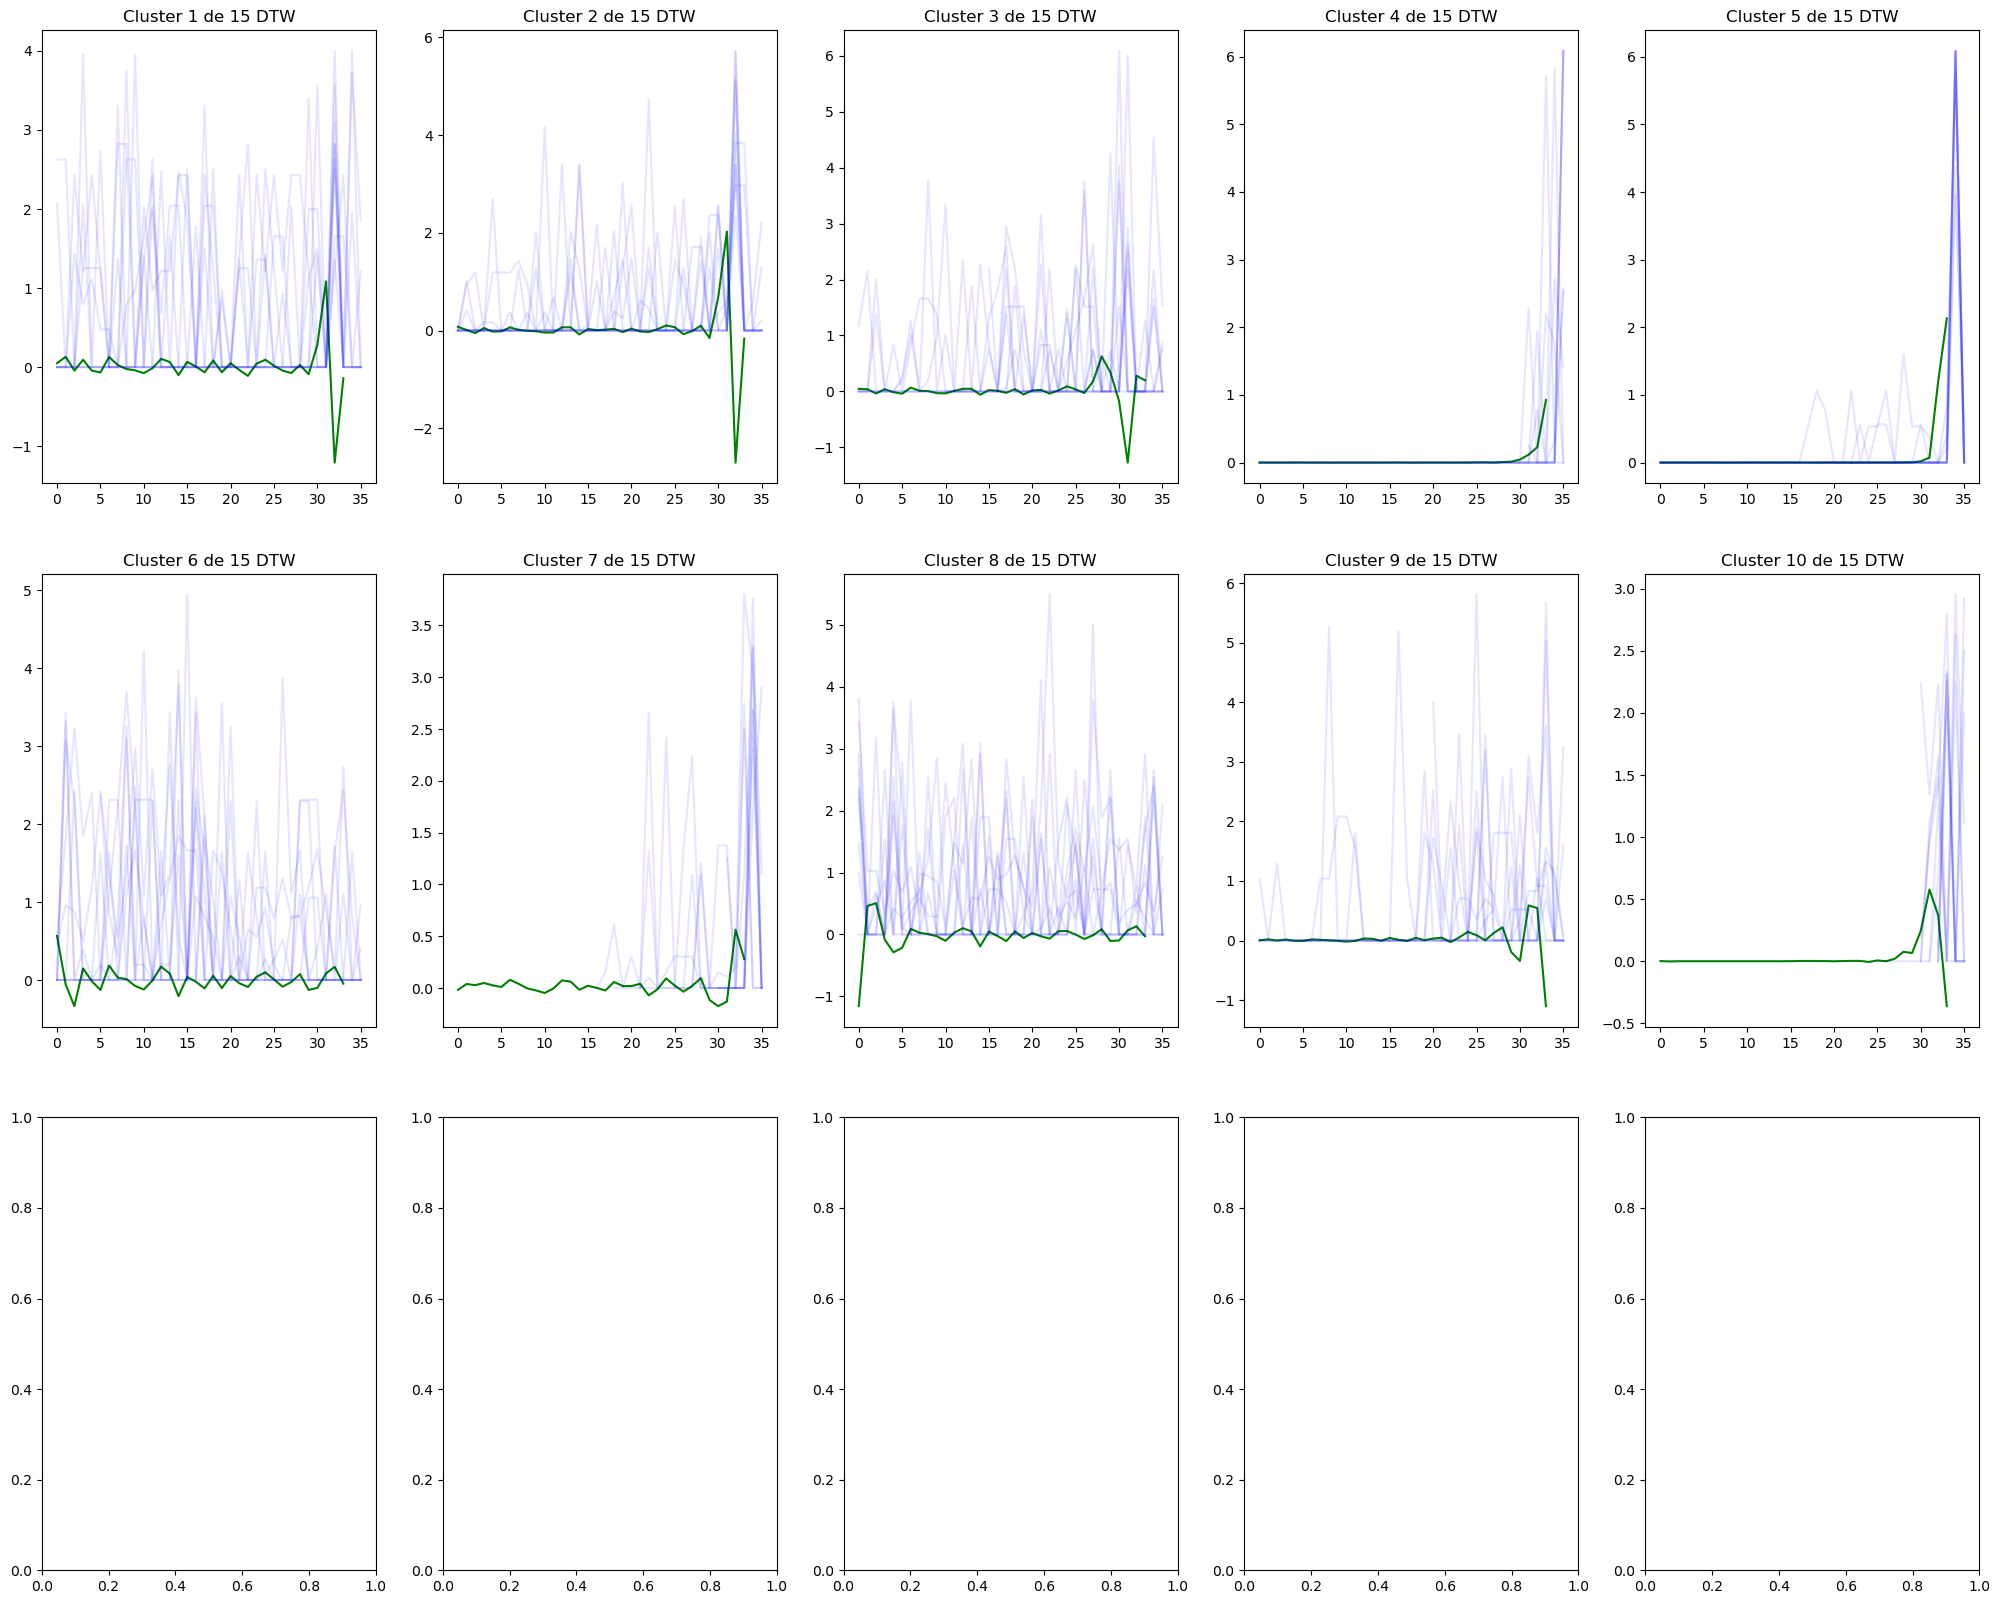

In [24]:
sample = 10
dibu_sample = pd.DataFrame()
fig, axs = plt.subplots(3, 5, figsize=(25, 20))

y_pred = x_clusters_dtw

for j in range(clusters[0]):
    axs[j//5, j%5].plot(model.cluster_centers_[j].ravel(), color='green')
    axs[j//5, j%5].set_title(f"Cluster {j+1} de {clusters[0]} DTW")
    try:
        dibu_sample = dibu[dibu['cluster']==j].sample(min(dibu[dibu['cluster']==j].shape[0],sample), random_state=42)
    except:
        continue
    
    for s in range(min(dibu_sample.shape[0],sample)):
        axs[j//5, j%5].plot(dibu_sample.iloc[s,3:].values, color='blue', alpha=0.1)

plt.tight_layout()

plt.show()

In [25]:
print(f"{fase:-^100}")
print(f"{'FINALIZA':-^100}\n\n\n")

----------------------------------------------02b_DTW-----------------------------------------------
----------------------------------------------FINALIZA----------------------------------------------



